# Notebook for an example Coronal Model Evaluation full cycle

In [1]:
from CHmetric import CHmetric, ezseg
from WLmetric import WLmetric, io_functions as io_WL
from NLmetric import NLmetric

from CHMAP import chmap

import datetime
import matplotlib.pyplot as plt
import pfsspy
import numpy as np
import sunpy.map

## Coronal Hole Metric

### Step 1 : Create Carrington Map using EUV data from +/- 14 days surrounding an input date

In [22]:
euvmappath = CHmetric.create_euv_map(datetime.datetime(2018,11,6),replace=False)

Searching for input EUV maps

Files Downloaded:   0%|          | 0/28 [00:00<?, ?file/s]

Reprojecting 28 Maps: 


/home/sbadman/1_RESEARCH/GIT_REPOS/CoronalModelEval/CHmetric/CHmetric.py:96: RuntimeWarning: Mean of empty slice
  np.nanmean([


In [23]:
euvmap = sunpy.map.Map(euvmappath)

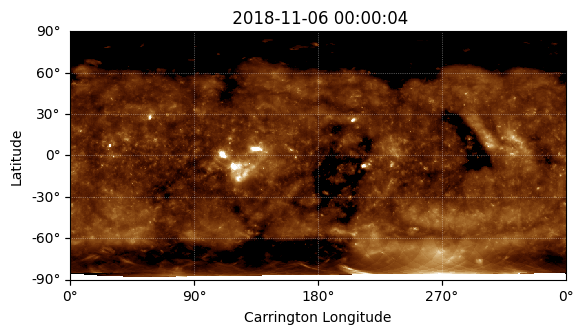

In [24]:
euvmap.plot(cmap="sdoaia193",
            vmin=np.nanpercentile(euvmap.data.flatten(),20),
            vmax=np.nanpercentile(euvmap.data.flatten(),99.9)
            
           )

### Step 2 : Extract Coronal Hole Contours with EZSEG

In [54]:
## Takes about a min to run in python
ch_obs_path = CHmetric.extract_obs_ch(euvmappath,
                                      replace=False,
                                      ezseg_params={
                                          "thresh1":1.5,#np.nanmax(euvmap.data.flatten())*0.07, ## Seed threshold
                                          "thresh2":1.75,#np.nanmax(euvmap.data.flatten())*0.101, ## Growing Threshhold
                                          "nc":5, ## at least 7 consecutive pixels to declare coronal hole area is connected
                                          "iters":100
                                      }
                                     )

ch_obs_map = sunpy.map.Map(ch_obs_path)

/home/sbadman/anaconda3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


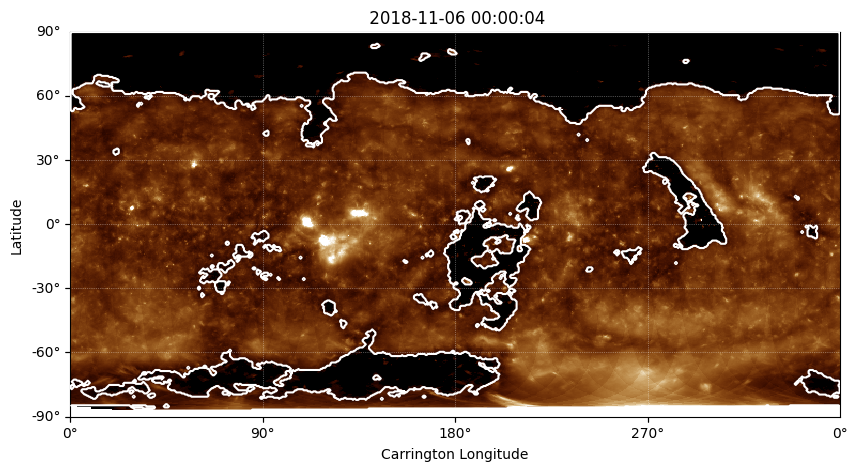

In [43]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=euvmap.wcs)
euvmap.plot(cmap="sdoaia193",
            vmin=np.nanpercentile(euvmap.data.flatten(),20),
            vmax=np.nanpercentile(euvmap.data.flatten(),99.9),
            axes=ax
           )
ch_obs_map.draw_contours(levels=[1],colors=["white"],axes=ax)

### Step 3 : Load in Model Coronal Hole Map and Run Binary Classifier to Score

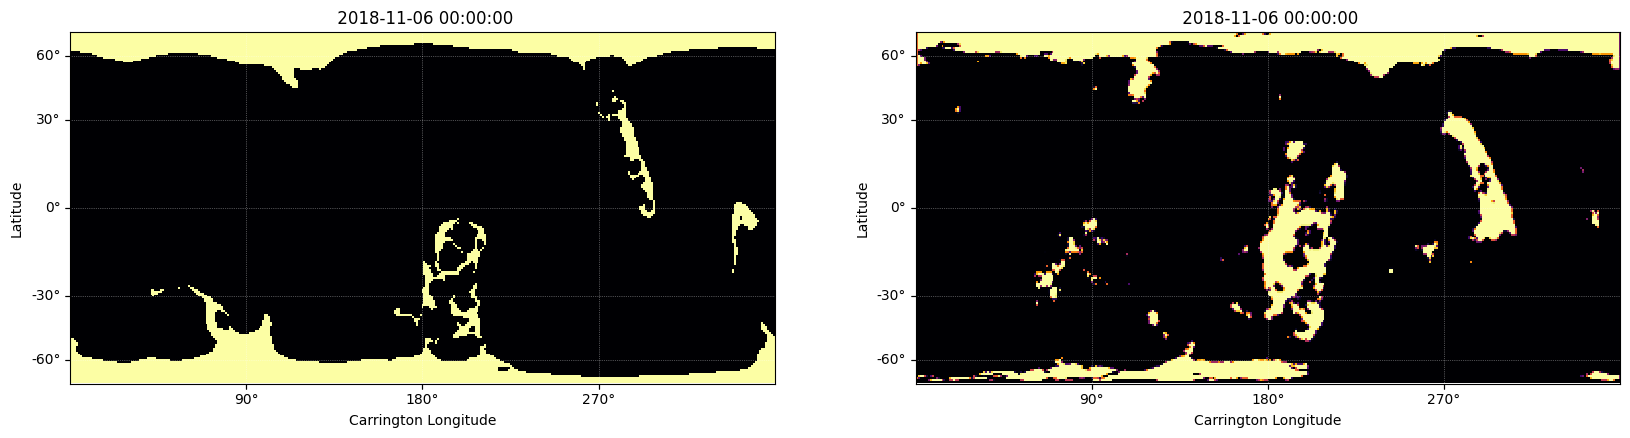

In [49]:
### We have some sample coronal hole and neutral line maps in the folder:
# ./example_model_data/
# Let's choose one
chmap_model_example_path = "./example_model_data/OpenFieldlineMap_Badman_AHMI_2018-11-06_2.5Rs.csv"

# Here's a function that can load these CSV files and port them into a sunpy.map
# as we've been working with above. We need to specify the model time, which we 
# can read from the filename.
datetime_model = datetime.datetime(2018,11,6)
chmap_model_example_map = CHmetric.csv2map(chmap_model_example_path,
                                           datetime_model
                                          )

### The model result y-axis is binned in the Cylindrical equal area projection
# while the observation is binned in latitude. We can convert one to the other
# by using the sunpy reprojection api (this also will interpolate the map to 
# the same resolution as the model result, which we also need for doing the
# pixel by pixel classification )
ch_obs_cea = ch_obs_map.reproject_to(chmap_model_example_map.wcs)

## Now we can plot this side by side with "observed" coronal holes and see
## how they compare
fig = plt.figure(figsize=(20,5))
axmodel = fig.add_subplot(121,projection=chmap_model_example_map.wcs) 
axobs = fig.add_subplot(122,projection=ch_obs_cea.wcs)
chmap_model_example_map.plot(cmap="inferno",axes=axmodel)
ch_obs_cea.plot(cmap="inferno",axes=axobs)

In [57]:
p,r,f = CHmetric.do_ch_score(datetime_model,
                             chmap_model_example_path,
                             ch_obs_path,
                             auto_interp=True)
print(f"Precision : {100*p:.1f}%, Recall : {100*r:.1f}%, F-Score : {100*f:.1f}%")

Precision : 58.8%, Recall : 60.9%, F-Score : 59.8%


## Streamer Belt Metric

### Step 1 - Create or Load a White Light Carrington Map

In [4]:
### Capability to create pending

### Load Precomputed Ones

## Download from IRAP Connect Tool connect-tool.irap.omp.eu
WL_date = datetime.datetime(2021,11,10)
WL_path = "./WLmetric/data/"
WL_source = "connect_tool"
[WL_fullpath,WL_date] = io_WL.get_WL_map(WL_date,WL_path,WL_source)

[WL_I, ## WL Intensity Map (reconstructed from RGB)
 WL_pphi, ##Pixel center meshgrid coords (lon)
 WL_tth, ## Pixel center meshgrid coords (lat)
 WL_I_edges, ## Evaluate WL intensity at cell edges
 WL_pphi_edges, ## Pixel edge meshgrid coords (lon)
 WL_tth_edges ## Pixel edge meshgrid coords (lat)
] = io_WL.read_WL_map_connecttool(WL_fullpath)

Fetching WL map from : http://connect-tool.irap.omp.eu/static/download_files/ALL_PARKER_PFSS_SCTIME_ADAPT_SCIENCE_20211110T000000.zip
./WLmetric/data/C2/connect_tool
100% [.................................................................] 6192406 / 6192406